## Makemore : part3

In [83]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [84]:
#------HYPERPARAMETERS
context_window = 3
n_emb = 10
n_hidden_neuron = 200
epoch = 100
l_r = 0.1
batch_size = 32
max_steps = 100000

In [85]:
words = open('names.txt', 'r').read().splitlines()

In [86]:
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [87]:
len(words)

32033

In [88]:
characters = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(characters)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [89]:
def build_dataset(words):
    X = []
    Y = []
    for word in words:
        context = [0]*context_window
        for ch in word + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%
            

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [45]:
g = torch.Generator().manual_seed(2323443222)

C = torch.randn(vocab_size, n_emb,                      generator = g)
W1 = torch.randn(context_window*n_emb, n_hidden_neuron, generator = g) *0.2
#b1 = torch.randn(n_hidden_neuron,                       generator = g) * 0
W2 = torch.randn(n_hidden_neuron, vocab_size,           generator = g) * 0.2
b2 = torch.randn(vocab_size,                            generator = g) * 0.1

bngain = torch.ones((1, n_hidden_neuron))
bnbias = torch.zeros((1, n_hidden_neuron))

bnmean_running = torch.ones((1, n_hidden_neuron))
bnstd_running = torch.zeros((1, n_hidden_neuron))

parameters = [C, W1, W2, b2, bngain, bnbias]

for p in parameters:
    p.requires_grad = True

print(sum(p.nelement() for p in parameters))

12097


In [ ]:
# plt.plot(lossi)

In [47]:
#------THE WAY ANDREJ DID IT
num_data = len(Xtr)
lossi = []

#------forward pass-----
for i in range(max_steps):
    #----mini-batch construction
    ix = torch.randint(0, num_data, (batch_size,), generator = g)
    X_batch = Xtr[ix]
    Y_batch = Ytr[ix]

    # --- forward pass
    emb = C[X_batch]
    emb_concat = emb.view(emb.shape[0], -1) #getting the input for NN

    # --- linear affine transformation
    hpreact = emb_concat @ W1 # + b1

    # --- batch normalization and keeping track of running mean and deviation
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # due to this line we will be removing b1, cause it has no use, it is getting subtracted
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    
    # --- Non- Linearity
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_batch)
    #print(f'hpreact: {hpreact.shape} b1: {b1.shape}') #this line is just to verify the shapes of tensors.
    #lossi.append(loss)


    
#-------backward pass
    for p in parameters:
        p.grad = None
    loss.backward()


#------Update Parameters---
    lr = 0.1 if i < 10000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad

#-----printing loss
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break

      0/ 100000: 2.2648


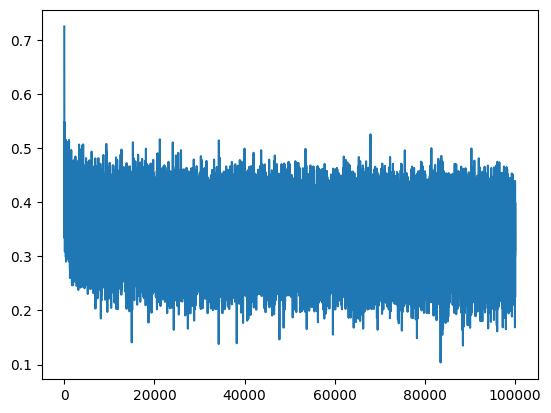

In [38]:
plt.plot(lossi)

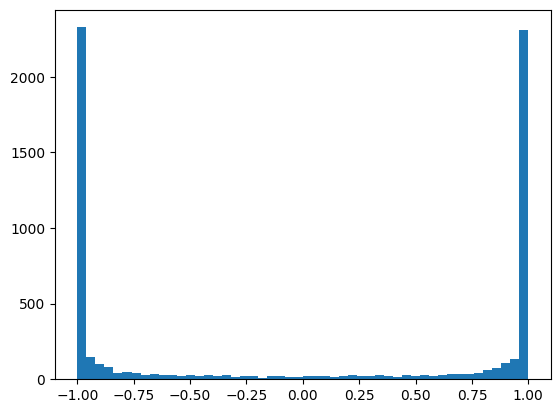

In [91]:
plt.hist(h.view(-1).tolist(), 50);

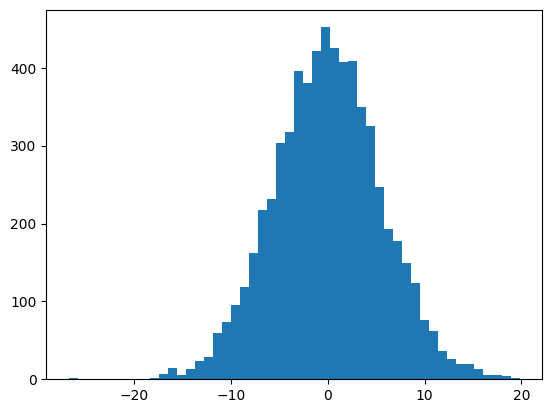

In [92]:
plt.hist(hpreact.view(-1).tolist(), 50);

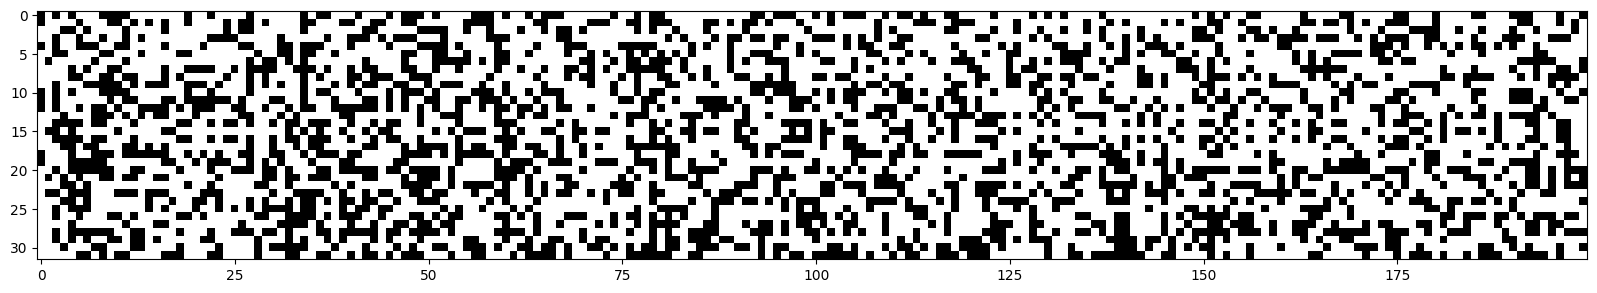

In [96]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='grey' ,interpolation='nearest')

In [20]:
with torch.no_grad():
    emb = C[Xtr]
    emb = emb.view(emb.shape[0], -1)
    hpreact = emb @ W1 + b1

    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)
    #this is kind of unnc=ecessary calculation so we will keep a running mean and variance while training

torch.Size([1, 200]) torch.Size([1, 200])
torch.Size([1, 200]) torch.Size([1, 200])


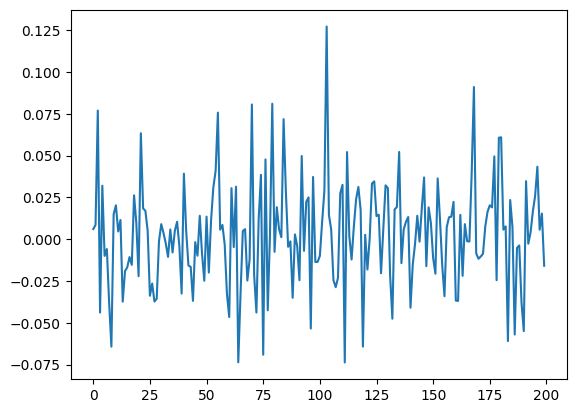

In [31]:
print(bnmean.shape, bnstd.shape)
print(bnmean_running.shape, bnstd_running.shape)
plt.plot(bnmean.view(-1)-bnmean_running.view(-1))
#plt.plot(bnmean_running.view(-1));

In [21]:
@torch.no_grad() #--this decorator disables gradient tracking
def split_loss(split):
    x,y = {'train': (Xtr, Ytr),
          'val': (Xdev, Ydev),
          'test': (Xte, Yte)}[split]
    emb = C[x]
    embConcat = emb.view(emb.shape[0], -1)
    hpreact = embConcat @ W1 + b1
    #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean_running) /bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,y)
    print(split, loss.item())

split_loss('val')
split_loss('test')

val 2.18898868560791
test 2.1884312629699707


In [72]:
g = torch.Generator().manual_seed(1234234231)

In [ ]:
#---NOT HOW ANDREJ DID BUT IT WORKS AND GURANTEES THAT WE ARE GOING THROUGH ALL DATA POINTS
# num_data = len(Xtr)
# lossi = []
# #------forward pass-----
# for _ in range(epoch):
#     indices = torch.randperm(num_data)
#     for i in range(0, num_data, batch_size):
#         ix = indices[i:i+batch_size]
#         X_batch = Xtr[ix]
#         Y_batch = Ytr[ix]
    
#         emb = C[X_batch]
#         emb_concat = emb.view(emb.shape[0], -1) #getting the input for NN
#         h = torch.tanh(emb_concat @ W1 + b1)
#         logits = h @ W2 + b2
#         loss = F.cross_entropy(logits, Y_batch)
#         lossi.append(loss.item())
#     #-------backward pass
#         for p in parameters:
#             p.grad = None
#         loss.backward()
    
    
#     #------Update Parameters---
#         for p in parameters:
#             p.data += -l_r*p.grad

#     #-----printing loss
#     print(loss)


In [75]:
#----sample from the modal
for _ in range(10):
    context = [0]*context_window
    out = []
    while True:
        emb = C[torch.tensor([context])] # (1, 3, 10)
        emb_concat = emb.view(1, -1) # (1, 30)
        h = torch.tanh(emb_concat @ W1 + b1) # (1, 100)
        logits = h @ W2 + b2 # (1, 27)
        prob = F.softmax(logits, dim = 1)  # (1, 27)
        ix = torch.multinomial(prob, num_samples=1, generator = g).item()
        if ix == 0:
            break
        context = context[1:] + [ix]
        out.append(itos[ix])
    print(''.join(out))
        

bria
aqses
ayla
arsi
saun
mara
adee
abetharashleight
degan
samaejah


In [159]:
#----pytorchifying our code
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g)  / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self. bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.01):
        self.eps = eps
        self.training = True
        self.momentum = momentum

        # parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        #buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        #setting mean and variance
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = x.running_var

        # Normalization
        xhat = (x - xmean) / torch.sqrt(xvar - self.eps)
        self.out = self.gamma * xhat + self.beta

        #updating the buffer 
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum)*self.running_mean + self.momentum*xmean
                self.running_var = (1-self.momentum)*self.running_var + self.momentum*xvar
        return self.out 

    def parameters(self):
        return [self.gamma, self.beta]

# class Tanh:
#     def __call__(self, x):
#         self.out = torch.tanh(x)
#         return self.out
#     def parameters(self):
#         return []

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

        
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
    Linear(n_embd * context_window, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * context_window, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
    layers[-1].gamma *= 0.1
    #layers[-1].weight *= 0.1
  # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            pass
            #layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

47024


In [161]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
        #print(layer.__class__.__name__)
    loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
  
  # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

  # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break 

      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.78%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.56%
layer 8 (      Tanh): mean -0.00, std 0.65, saturated: 2.25%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.69%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 1.88%


Text(0.5, 1.0, 'activation distribution')

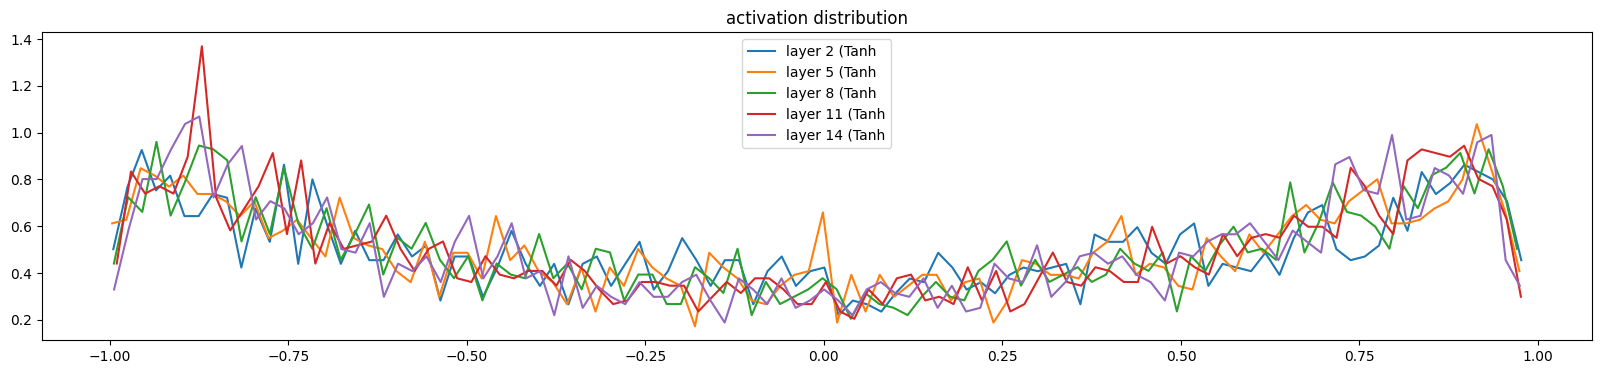

In [162]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 2.640702e-03
layer 5 (      Tanh): mean +0.000000, std 2.245597e-03
layer 8 (      Tanh): mean +0.000000, std 2.045729e-03
layer 11 (      Tanh): mean +0.000000, std 1.983172e-03
layer 14 (      Tanh): mean -0.000000, std 1.952388e-03


Text(0.5, 1.0, 'gradient distribution')

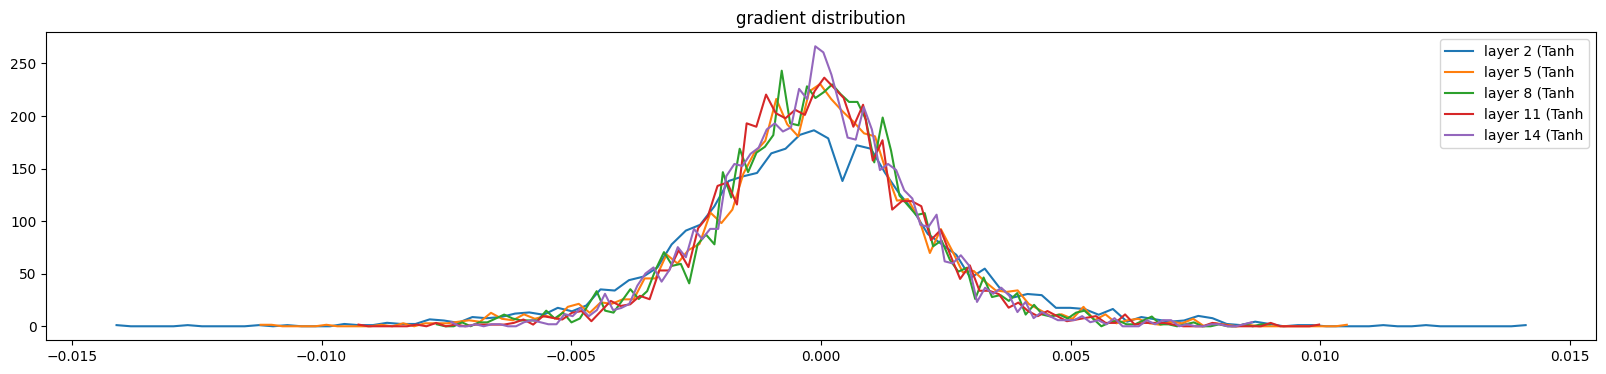

In [163]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 8.020854e-03 | grad:data ratio 8.012950e-03
weight  (30, 100) | mean +0.000246 | std 9.241291e-03 | grad:data ratio 4.881203e-02
weight (100, 100) | mean +0.000113 | std 7.133081e-03 | grad:data ratio 6.964814e-02
weight (100, 100) | mean -0.000086 | std 6.234379e-03 | grad:data ratio 6.073811e-02
weight (100, 100) | mean +0.000052 | std 5.742320e-03 | grad:data ratio 5.631611e-02
weight (100, 100) | mean +0.000032 | std 5.672516e-03 | grad:data ratio 5.570428e-02
weight  (100, 27) | mean -0.000082 | std 1.209420e-02 | grad:data ratio 1.160111e-01


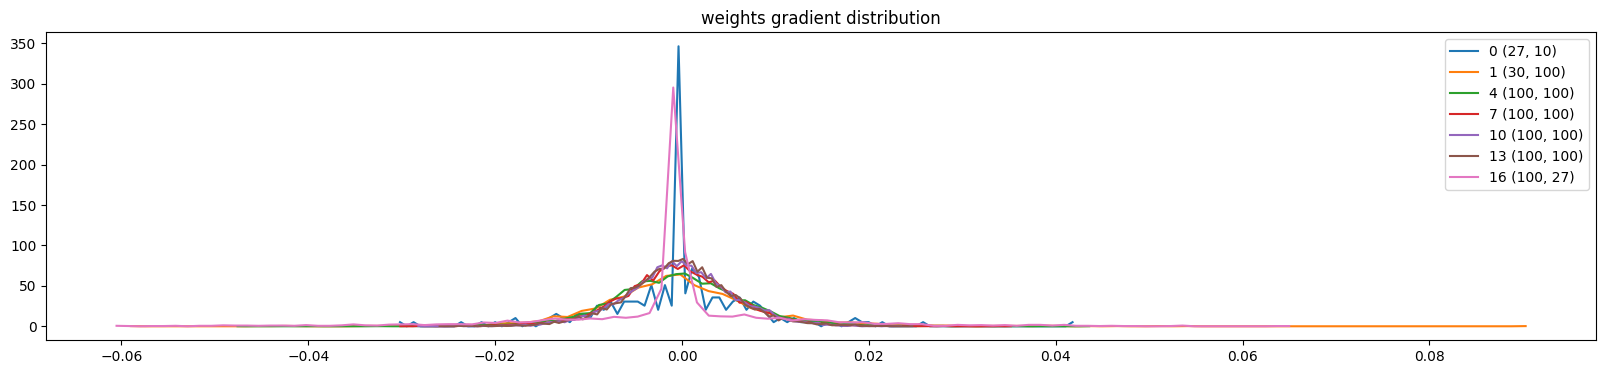

In [164]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

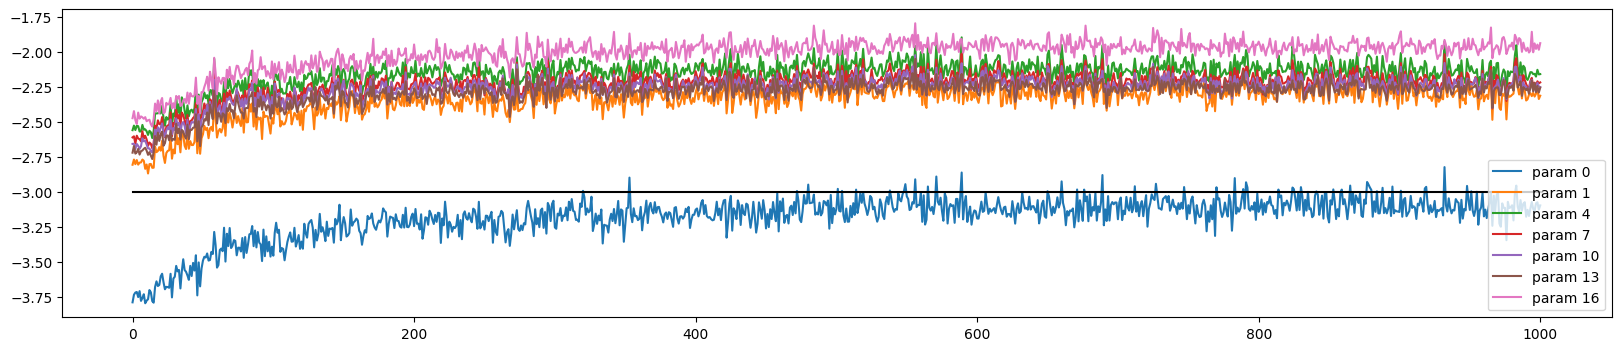

In [165]:
# plotting update/data
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);